### Run, train and validate DNN (PyTorch Model)

Pre-process the data, train and validate models using AUC as the performance metric

In [1]:
import pandas as pd
import boto3
import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.tuner import (
    IntegerParameter,
    ContinuousParameter,
    CategoricalParameter,
    HyperparameterTuner,
)


from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix

role = get_execution_role()
session = sagemaker.Session()
sklearn_v = "0.20.0"

import SKLearn_input_prep
import plot_hyperparameter_tuning as plt_hyper

In [2]:
# create a list of the features to use for modeling

feat_list = [
    "CUST_PRICE_SENSITIVITY",
    "CUST_LIFESTAGE",
    "BASKET_SIZE_PROP_SPEND_PROD_CODE_M",
    "BASKET_PRICE_SENSITIVITY_SPEND_CUST_CODE_LA",
    "DAY_PART_PROP_SPEND_CUST_CODE_AFTERNOON",
    "BASKET_SIZE_PROP_VISITS_CUST_CODE_L",
    "BASKET_DOMINANT_MISSION_PROP_SPEND_PROD_CODE_Fresh",
    "BASKET_TYPE_PROP_VISITS_CUST_CODE_Small Shop",
    "BASKET_SIZE_PROP_QUANTITY_PROD_CODE_L",
    "STORE_FORMAT_PROP_VISITS_CUST_CODE_MS",
    "CHNG_VISITS_PROD_CODE_30_1_52",
    "STORE_FORMAT_PROP_SPEND_PROD_CODE_LS",
    "STORE_FORMAT_PROP_QUANTITY_CUST_CODE_SS",
    "BASKET_SIZE_QUANTITY_CUST_CODE_S",
    "BASKET_DOMINANT_MISSION_PROP_QUANTITY_PROD_CODE_Nonfood",
    "CHNG_SPEND_PROD_CODE_40_8_52",
    "BASKET_DOMINANT_MISSION_PROP_VISITS_CUST_CODE_XX",
    "BASKET_TYPE_VISITS_CUST_CODE_XX",
    "WKDAY_WKEND_PROP_QUANTITY_CUST_CODE_WEEKEND",
    "BASKET_TYPE_QUANTITY_CUST_CODE_Small Shop",
    "SPEND_PROD_CODE_30_52",
    "BASKET_TYPE_SPEND_CUST_CODE_Top Up",
    "BASKET_DOMINANT_MISSION_PROP_SPEND_CUST_CODE_Grocery",
    "CHNG_QUANTITY_PROD_CODE_40_26_52",
    "SPEND_PROD_CODE_20_52",
    "BASKET_TYPE_PROP_QUANTITY_CUST_CODE_Top Up",
    "VISITS_PROD_CODE_20_52",
    "WKDAY_WKEND_PROP_VISITS_PROD_CODE_WEEKEND",
    "VISITS_PROD_CODE_40_1",
    "CHNG_VISITS_PROD_CODE_40_1_26",
    "BASKET_TYPE_PROP_SPEND_PROD_CODE_XX",
    "STORE_FORMAT_PROP_VISITS_CUST_CODE_XLS",
    "DAY_PART_PROP_VISITS_CUST_CODE_EVENING",
    "TIME_BTWN_MEDIAN_OVERALL_PROD_CODE_40",
    "STORE_FORMAT_PROP_VISITS_PROD_CODE_XLS",
    "DAY_PART_PROP_SPEND_PROD_CODE_MORNING",
    "STORE_FORMAT_PROP_SPEND_PROD_CODE_SS",
    "STORE_FORMAT_PROP_VISITS_PROD_CODE_MS",
    "DAY_PART_PROP_SPEND_CUST_CODE_MORNING",
    "BASKET_PRICE_SENSITIVITY_PROP_SPEND_PROD_CODE_LA",
    "DAY_PART_PROP_QUANTITY_PROD_CODE_EVENING",
    "BASKET_PRICE_SENSITIVITY_SPEND_CUST_CODE_UM",
    "BASKET_DOMINANT_MISSION_PROP_SPEND_PROD_CODE_Grocery",
    "BASKET_PRICE_SENSITIVITY_PROP_QUANTITY_PROD_CODE_MM",
    "STORE_FORMAT_PROP_SPEND_CUST_CODE_LS",
    "QUANTITY_PROD_CODE_52",
    "BASKET_TYPE_PROP_VISITS_PROD_CODE_Top Up",
    "DAY_PART_PROP_SPEND_PROD_CODE_AFTERNOON",
    "CHNG_VISITS_PROD_CODE_20_1_8",
    "BASKET_PRICE_SENSITIVITY_PROP_QUANTITY_CUST_CODE_MM",
    "BASKET_DOMINANT_MISSION_SPEND_CUST_CODE_XX",
    "USER_factor_0",
    "USER_factor_1",
    "USER_factor_2",
    "USER_factor_3",
    "USER_factor_4",
    "ITEM_factor_0",
    "ITEM_factor_1",
    "ITEM_factor_2",
    "ITEM_factor_3",
    "ITEM_factor_4",
]

In [3]:
sklearn_processor = SKLearnProcessor(
    framework_version=sklearn_v,
    role=role,
    instance_type="ml.m5.xlarge",
    instance_count=1,
)

### Pre-process the data

In [4]:
# Keep only the specified features from the training and test sets that will be used for model developement
input_data_train, input_data_test = SKLearn_input_prep.create_model_input(
    bucket="udacity-machine-learning-capstone-data",
    train_key="train_df_features.csv",
    test_key="test_df_features.csv",
    out_file_train="train_df_final_features.csv",
    out_file_test="test_df_final_features.csv",
    feat_list=feat_list,
)

# Run the pre-processing steps by calling preprocessing.py
sklearn_processor.run(
    code="preprocessing_pytorch_model.py",
    inputs=[
        ProcessingInput(
            source=input_data_train, destination="/opt/ml/processing/input_data_train"
        ),
        ProcessingInput(
            source=input_data_test, destination="/opt/ml/processing/input_data_test"
        ),
    ],
    outputs=[
        ProcessingOutput(output_name="train_data", source="/opt/ml/processing/train"),
        ProcessingOutput(output_name="test_data", source="/opt/ml/processing/test"),
        ProcessingOutput(output_name="valid_data", source="/opt/ml/processing/valid"),
    ],
    arguments=["--train-test-split-ratio", "0.2"],
)

preprocessing_job_description = sklearn_processor.jobs[-1].describe()

output_config = preprocessing_job_description["ProcessingOutputConfig"]
for output in output_config["Outputs"]:
    if output["OutputName"] == "train_data":
        preprocessed_training_data = output["S3Output"]["S3Uri"]
    if output["OutputName"] == "test_data":
        preprocessed_test_data = output["S3Output"]["S3Uri"]
    if output["OutputName"] == "valid_data":
        preprocessed_valid_data = output["S3Output"]["S3Uri"]


Job Name:  sagemaker-scikit-learn-2020-03-10-22-53-59-473
Inputs:  [{'InputName': 'input-1', 'S3Input': {'S3Uri': 's3://udacity-machine-learning-capstone-data/train_df_final_features.csv', 'LocalPath': '/opt/ml/processing/input_data_train', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'input-2', 'S3Input': {'S3Uri': 's3://udacity-machine-learning-capstone-data/test_df_final_features.csv', 'LocalPath': '/opt/ml/processing/input_data_test', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'S3Input': {'S3Uri': 's3://sagemaker-us-east-2-800613416076/sagemaker-scikit-learn-2020-03-10-22-53-59-473/input/code/preprocessing_pytorch_model.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'No

In [5]:
train_df = pd.read_csv(preprocessed_training_data + "/train_df.csv")
print("Training DataFrame shape: {}".format(train_df.shape))
train_df.head(n=10)

Training DataFrame shape: (18652, 71)


,TARGET,BASKET_SIZE_PROP_SPEND_PROD_CODE_M,BASKET_PRICE_SENSITIVITY_SPEND_CUST_CODE_LA,DAY_PART_PROP_SPEND_CUST_CODE_AFTERNOON,BASKET_SIZE_PROP_VISITS_CUST_CODE_L,BASKET_DOMINANT_MISSION_PROP_SPEND_PROD_CODE_Fresh,BASKET_TYPE_PROP_VISITS_CUST_CODE_Small Shop,BASKET_SIZE_PROP_QUANTITY_PROD_CODE_L,STORE_FORMAT_PROP_VISITS_CUST_CODE_MS,CHNG_VISITS_PROD_CODE_30_1_52,...,x0_MM,x0_UM,x0_XX,x1_OA,x1_OF,x1_OT,x1_PE,x1_XX,x1_YA,x1_YF
0,1.0,4.126890,-0.376453,-1.378870,1.082173,-0.810606,-0.806275,-2.572434,-0.561918,-0.177029,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.137103,-0.094667,0.337954,-0.203006,0.469229,0.089560,0.021770,0.912198,-0.177029,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.059633,-0.325516,0.982212,0.851148,0.315727,-0.582191,-0.160575,-0.402554,-0.177029,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,4.126890,0.274827,0.771434,-0.304365,1.851930,0.517465,-2.572434,-0.519190,-0.177029,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,1.846573,1.155495,-0.431237,1.410940,0.471356,-1.078115,-0.970354,2.386313,-0.177029,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,0.0,-0.561912,-0.045304,0.143303,-0.418907,0.523798,0.853377,0.704548,2.347521,0.331831,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,0.0,-1.003824,-0.249166,0.449536,-0.409922,-1.698119,0.897950,1.032246,1.479165,-0.177029,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,1.0,0.222099,-0.404790,-1.321283,-1.547961,0.524589,1.857753,-0.036398,0.027728,-0.177029,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,1.0,-0.907018,-0.404790,-1.483189,-1.547961,-0.492442,-1.078115,0.964233,-0.561918,-0.177029,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,1.0,0.861890,-0.301678,0.596331,1.410940,-0.891289,-1.078115,-0.606245,2.386313,-0.177029,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Train, tune and evaluate DNN model

#### Tune the hyperparameters

In [6]:
# get the number of input features
input_features = train_df.shape[1] - 1

# get the test set batch size (whole dataset)
test_df = pd.read_csv(preprocessed_test_data + "/test_df.csv")
test_batch_size = test_df.shape[0]

# instantiate a pytorch estimator
estimator = PyTorch(
    entry_point="train.py",
    source_dir="source_pytorch",
    role=role,
    framework_version="1.0",
    train_instance_count=1,
    train_instance_type="ml.c4.xlarge",
    metric_definitions=[
        {"Name": "Test Accuracy", "Regex": "Test Accuracy: ([0-9\\.]+)"}
    ],
    hyperparameters={
        "input_features": input_features,
        "test_batch_size": test_batch_size,
        "output_dim": 1,
    },
)

# Set up the hyperparameter tuning job
hyperparameter_tuner = HyperparameterTuner(
    estimator=estimator,
    objective_metric_name="Test Accuracy",
    objective_type="Maximize",
    metric_definitions=[
        {"Name": "Test Accuracy", "Regex": "Test Accuracy: ([0-9\\.]+)"}
    ],
    max_jobs=50,
    max_parallel_jobs=10,
    hyperparameter_ranges={
        "num_layers": IntegerParameter(1, 10),
        "hidden_dim": IntegerParameter(1, 512),
        "dropout_rate": ContinuousParameter(0, 0.2),
        "momentum": ContinuousParameter(0.8, 1),
        "train_batch_size": IntegerParameter(32, 500),
        "epochs": IntegerParameter(1, 50),
        "lr": ContinuousParameter(0.001, 0.2),
    },
)

hyperparameter_tuner.fit(
    {"train": preprocessed_training_data, "test": preprocessed_test_data}
)
hyperparameter_tuner.wait()

..........................................................................................................................................................................................................................................!


In [7]:
# Get analysis on the tuning job including best hyperparameters
tuning_analysis = (
    hyperparameter_tuner.analytics()
    .dataframe()
    .sort_values(by=["TrainingStartTime"], ascending=False, axis=0)
)
tuning_analysis["iteration"] = tuning_analysis.index
tuning_analysis.sort_values(
    by=["FinalObjectiveValue"], ascending=False, axis=0, inplace=True
)

tuning_analysis.head()

,FinalObjectiveValue,TrainingElapsedTimeSeconds,TrainingEndTime,TrainingJobName,TrainingJobStatus,TrainingStartTime,dropout_rate,epochs,hidden_dim,lr,momentum,num_layers,train_batch_size,iteration
0,0.506631,46.0,2020-03-10 23:17:05+00:00,sagemaker-pytorch-200310-2257-050-14dcdb3d,Completed,2020-03-10 23:16:19+00:00,0.063485,8.0,5.0,0.053774,0.803991,2.0,330.0,0
36,0.506631,106.0,2020-03-10 23:04:31+00:00,sagemaker-pytorch-200310-2257-014-6dc75e1b,Completed,2020-03-10 23:02:45+00:00,0.188536,14.0,303.0,0.093983,0.884515,4.0,116.0,36
27,0.506631,352.0,2020-03-10 23:12:36+00:00,sagemaker-pytorch-200310-2257-023-9e94deaa,Completed,2020-03-10 23:06:44+00:00,0.169066,35.0,244.0,0.108319,0.955861,10.0,150.0,27
28,0.506631,72.0,2020-03-10 23:07:44+00:00,sagemaker-pytorch-200310-2257-022-ba22881f,Completed,2020-03-10 23:06:32+00:00,0.037093,3.0,213.0,0.052435,0.992928,1.0,208.0,28
29,0.506631,132.0,2020-03-10 23:08:41+00:00,sagemaker-pytorch-200310-2257-021-2a7b0ce0,Completed,2020-03-10 23:06:29+00:00,0.165117,25.0,209.0,0.028849,0.824670,10.0,478.0,29


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


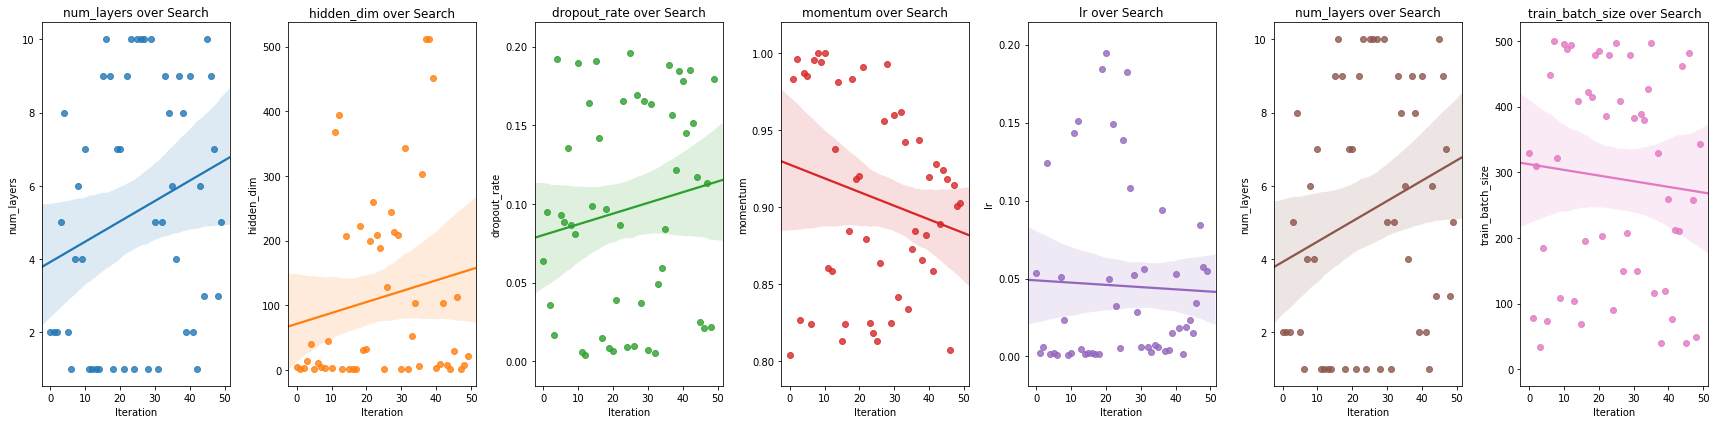

In [8]:
# Plot the value of hyperparameters over the tuning window
plt_hyper.plot_hyperparams_over_search(
    df=tuning_analysis,
    hyperparams=[
        "num_layers",
        "hidden_dim",
        "dropout_rate",
        "momentum",
        "lr",
        "num_layers",
        "train_batch_size",
    ],
)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


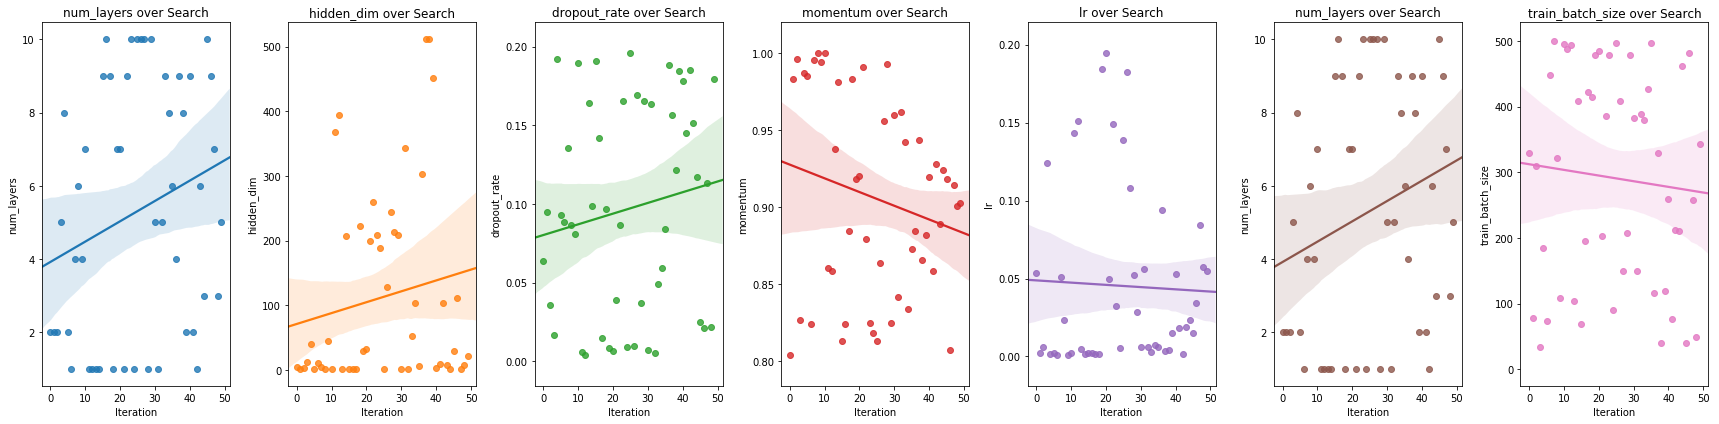

In [9]:
# Plot the value of hyperparameters over the tuning window
plt_hyper.plot_hyperparams_over_search(
    df=tuning_analysis,
    hyperparams=[
        "num_layers",
        "hidden_dim",
        "dropout_rate",
        "momentum",
        "lr",
        "num_layers",
        "train_batch_size",
    ],
)

### Evaluate performance on the validation set

In [10]:
torch_attached = PyTorch.attach(hyperparameter_tuner.best_training_job())
torch_transformer = torch_attached.transformer(
    instance_count=1, instance_type="ml.m4.xlarge"
)

valid_df = pd.read_csv(preprocessed_valid_data + "/valid_df.csv")
y_valid = valid_df[['TARGET']]
valid_df = valid_df.drop('TARGET', axis = 1)
valid_df = valid_df.astype('float16')

out_file="torch_valid_df.csv"
valid_df.to_csv('./{}'.format(out_file), header=None, index_label=None)
bucket="udacity-machine-learning-capstone-data"

boto3.Session().resource("s3").Bucket(bucket).Object(out_file).upload_file(
        "./{}".format(out_file)
    )

torch_transformer.transform(
    "s3://{}/{}".format(bucket, out_file),
    content_type="text/csv",
    split_type="Line",
)
torch_transformer.wait()

2020-03-10 23:14:34 Starting - Preparing the instances for training
2020-03-10 23:14:34 Downloading - Downloading input data
2020-03-10 23:14:34 Training - Training image download completed. Training in progress.
2020-03-10 23:14:34 Uploading - Uploading generated training model
2020-03-10 23:14:34 Completed - Training job completedbash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-03-10 23:14:18,190 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-03-10 23:14:18,191 sagemaker-containers INFO     Failed to parse hyperparameter _tuning_objective_metric value Test Accuracy to Json.
Returning the value itself
2020-03-10 23:14:18,193 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-03-10 23:14:18,205 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-03-10 23:14:19,632 sagemaker_pytorch_container.training INFO

......................bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
[2020-03-10 23:21:01 +0000] [20] [INFO] Starting gunicorn 19.9.0
[2020-03-10 23:21:01 +0000] [20] [INFO] Listening at: unix:/tmp/gunicorn.sock (20)
[2020-03-10 23:21:01 +0000] [20] [INFO] Using worker: gevent
[2020-03-10 23:21:01 +0000] [27] [INFO] Booting worker with pid: 27
[2020-03-10 23:21:01 +0000] [28] [INFO] Booting worker with pid: 28
[2020-03-10 23:21:01 +0000] [32] [INFO] Booting worker with pid: 32
[2020-03-10 23:21:01 +0000] [33] [INFO] Booting worker with pid: 33

Processing /opt/ml/code
  Running setup.py bdist_wheel for train: started
  Running setup.py bdist_wheel for train: finished with status 'done'
  Stored in directory: /tmp/pip-ephem-wheel-cache-mm8s8rwi/wheels/35/24/16/37574d11bf9bde50616c67372a334f94fa8356bc7164af8ca3
Successfully built train
You are using pip version 18.1, however version 20.0.2 is available.
You should consider 

UnexpectedStatusException: Error for Transform job sagemaker-pytorch-200310-2257-040-579ce-2020-03-10-23-17-34-837: Failed. Reason: AlgorithmError: See job logs for more information

In [ ]:
# Copy the predictions from S3 and read to csv
!aws s3 cp --recursive $torch_transformer.output_path $data_dir
y_pred = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

# Create the classification report
report_dict = classification_report(y_valid, y_pred, output_dict=True)
report_dict["accuracy"] = accuracy_score(y_valid, predictions)
report_dict["roc_auc"] = roc_auc_score(y_valid, predictions)

print("Classification report:\n{}".format(report_dict))